Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):

01-06 SOUID: Source identifier

08-15 DATE : Date YYYYMMDD

17-21 TG   : mean temperature in 0.1 &#176;C

23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).

Blended and updated with sources: 111448 127488 128124 

See file sources.txt and stations.txt for more info.

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# statistics stack
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
FILE_PATH = "/Users/elizavetabugaeva/Documents/Spiced/weekly_milestones/week_07/ECA_blended_custom/TG_STAID002759.txt"

df = pd.read_csv(
FILE_PATH,
#start from row 20
skiprows=19,
skipinitialspace = True,
#column #1 is dates in our original data 
parse_dates = [1]
)

In [3]:
df

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0
...,...,...,...,...
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0


In [4]:
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0


In [5]:
df.tail()

,SOUID,DATE,TG,Q_TG
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0
53780,111448,2023-03-31,108,0


In [6]:
df_missing = df[df['Q_TG']==9]

In [7]:
df_missing['DATE'].min()

Timestamp('1945-04-25 00:00:00')

In [8]:
df_missing['DATE'].max()

Timestamp('1945-11-05 00:00:00')

In [9]:
#number of days with missing vallues
missing_days= (df_missing['DATE'].max() - df_missing['DATE'].min()).days +1
missing_days

195

In [10]:
#check is all missing days actually miss values
missing_days == df_missing.shape[0]

True

## Data Preprocessing

Missing days need to be inputed for the model to work

In [11]:
from dateutil.relativedelta import relativedelta

In [12]:
# reference years are all years 5 years before and  5 years after
reference_years = list(range(-5,6))
reference_years.remove(0)
# function for clean temperature values
def clean_temp(df,x):
    """
    returns a temperaure column in celcius with missing values imputed;
    imputation is done with the average of the temperautes on the same
    day over all the reference years; division by 10 for celcius value
    """
    # if missing value occurs
    if x['Q_TG']==9:
        # list reference dates
        reference_dates = [x['DATE']+relativedelta(years=y) for y in reference_years]
        # mean temperatue over the references dates
        temp_value = df[df['DATE'].isin(reference_dates)]['TG'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['TG']/10

In [13]:
# create clean temperatutre column
df['TEMP'] = df.apply(
    lambda x: clean_temp(df,x),
    axis=1
)

In [14]:
#check that values are filled out
df[df['DATE']=='1945-07-25']

,SOUID,DATE,TG,Q_TG,TEMP
25407,127488,1945-07-25,-9999,9,20.6


In [15]:
df

,SOUID,DATE,TG,Q_TG,TEMP
0,127488,1876-01-01,22,0,2.2
1,127488,1876-01-02,25,0,2.5
2,127488,1876-01-03,3,0,0.3
3,127488,1876-01-04,-58,0,-5.8
4,127488,1876-01-05,-98,0,-9.8
...,...,...,...,...,...
53776,111448,2023-03-27,34,0,3.4
53777,111448,2023-03-28,35,0,3.5
53778,111448,2023-03-29,66,0,6.6
53779,111448,2023-03-30,117,0,11.7


### Train-test split

In [16]:
df.columns = df.columns.str.lower()
clean_df = df.set_index('date')[['temp']]

In [17]:
clean_df.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [18]:
df.shape

(53781, 5)

In [19]:
train = clean_df[:'2022-12-31']
train.shape

(53691, 1)

In [20]:
test = clean_df['2023-01-01':]

In [21]:
test.shape

(90, 1)

In [22]:
train.to_csv('temp_train.csv')
test.to_csv('temp_test.csv')

### Split data to noise and denoised

In [23]:
#import savitzky-golay filter
from scipy.signal import savgol_filter

In [24]:
train['denoised']=savgol_filter(np.array(train['temp']),99,3, mode='nearest')

In [25]:
train['denoised']

date
1876-01-01   -0.659391
1876-01-02   -0.772946
1876-01-03   -0.858296
1876-01-04   -1.025494
1876-01-05   -1.151521
                ...   
2022-12-27    6.827954
2022-12-28    7.212065
2022-12-29    7.611574
2022-12-30    8.021626
2022-12-31    8.411407
Name: denoised, Length: 53691, dtype: float64

<AxesSubplot:xlabel='date'>

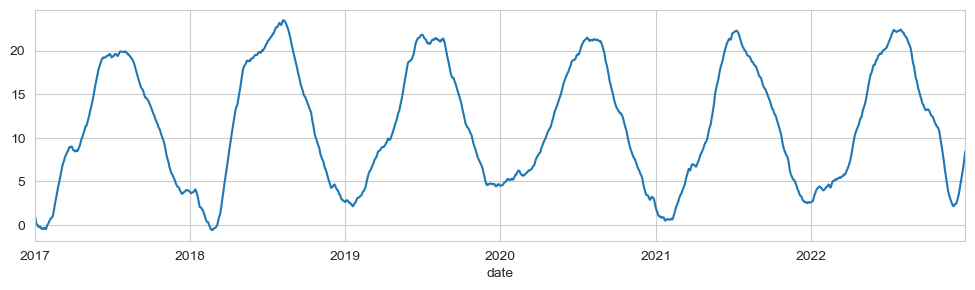

In [26]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train['denoised']['2017-01-01':'2022-12-31'].plot()

In [27]:
test['denoised']=savgol_filter(np.array(test['temp']),99,3, mode='nearest')

### Noise

In [28]:
train['noise'] = train['temp'] - train['denoised']

In [29]:
test['noise'] = test['temp'] - test['denoised']

<AxesSubplot:xlabel='date'>

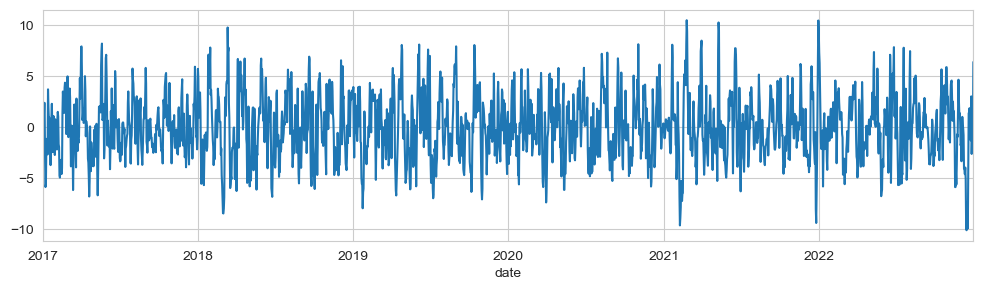

In [30]:
train['noise']['2017-01-01':'2022-12-31'].plot()

## Working with denoised data only

In [31]:
#calculate qcd
def qcd_variance(series,window=250): #12 because we work with months
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")
    
    #this function tells you if the series varies a lot or not

In [32]:
qcd_variance(train['denoised'])

quartile coefficient of dispersion: 0.278501


quartile coefficient of dispersion is close to 1 and tranformationd do not help -> will be using multiplicative model in the end 

## Baseline Model

### Trend

In [33]:
train['timestep']= list(range(0,train.shape[0]))

In [34]:
X_trend = train[['timestep']]
y_trend = train['denoised']

In [35]:
trend_model = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [36]:
trend_model.fit(X_trend,y_trend)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

## Prediction of the trend for denoised data

In [37]:
train['trend_denoised'] = trend_model.predict(X_trend)

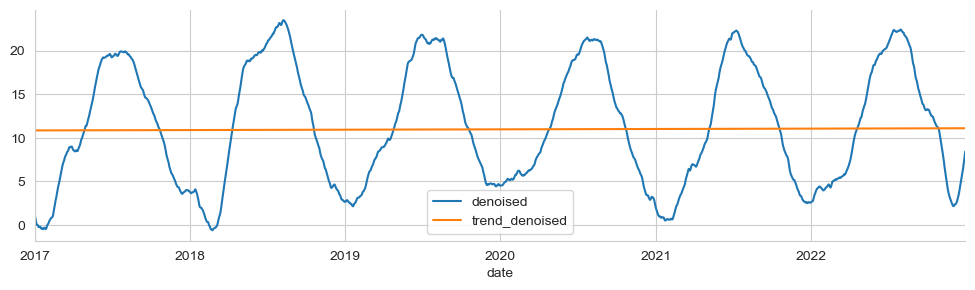

In [38]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['denoised','trend_denoised']]['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

### Seasonality

In [39]:
#denoised detrended data
train['detrended_d'] = train['denoised'] - train['trend_denoised']

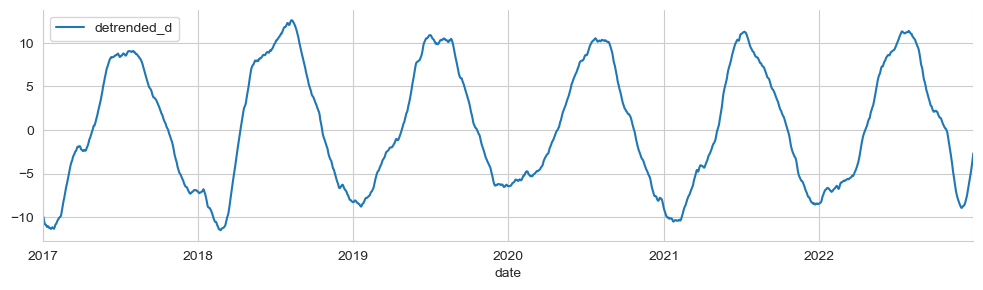

In [40]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended_d']['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

<AxesSubplot:xlabel='date'>

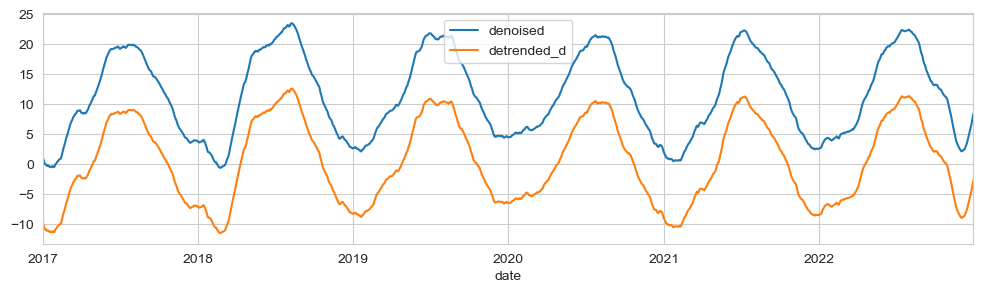

In [41]:
train[['denoised','detrended_d']]['2017-01-01':'2022-12-31'].plot(legend=True)

## Extracting seasonality 

In [42]:
# Convert the index to a pandas DatetimeIndex
clean_df.index = pd.to_datetime(clean_df.index)

# Extract day of the year from the index and normalize it to range from 0 to 1
day_of_year = clean_df.index.dayofyear
day_of_year_normalized = (day_of_year - 1) / 365.24

# Create a seasonality column with values ranging from 0 to 1
clean_df['seasonality'] = day_of_year_normalized

In [43]:
X_season = clean_df.loc[:'2022-12-31', ['seasonality']]
y_season = train['detrended_d']

In [44]:
X_season

,seasonality
date,
1876-01-01,0.000000
1876-01-02,0.002738
1876-01-03,0.005476
1876-01-04,0.008214
1876-01-05,0.010952
...,...
2022-12-27,0.985653
2022-12-28,0.988391
2022-12-29,0.991129


In [45]:
seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [46]:
seasonality_model.fit(X_season, y_season)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [47]:
train['seasonality'] = seasonality_model.predict(X_season)

In [48]:
train['seasonality']

date
1876-01-01   -9.067679
1876-01-02   -9.103861
1876-01-03   -9.141828
1876-01-04   -9.176523
1876-01-05   -9.206905
                ...   
2022-12-27   -8.820279
2022-12-28   -8.848868
2022-12-29   -8.883836
2022-12-30   -8.922330
2022-12-31   -8.965668
Name: seasonality, Length: 53691, dtype: float64

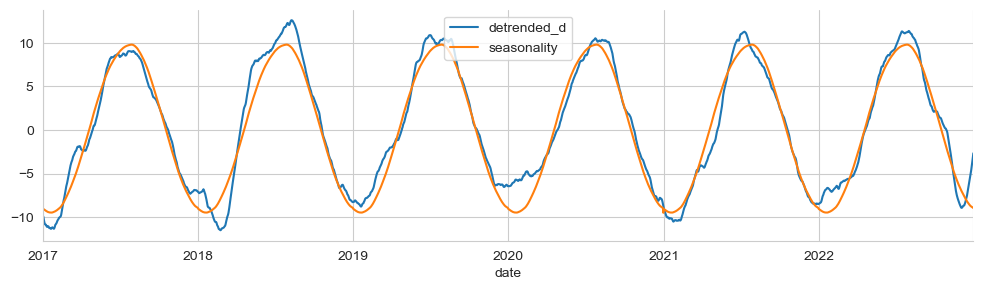

In [49]:
#plot seasonality prediction vs detranded data
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended_d','seasonality']]['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

## Baseline Model

In [50]:
train['baseline_denoised'] = train['trend_denoised'] + train['seasonality']

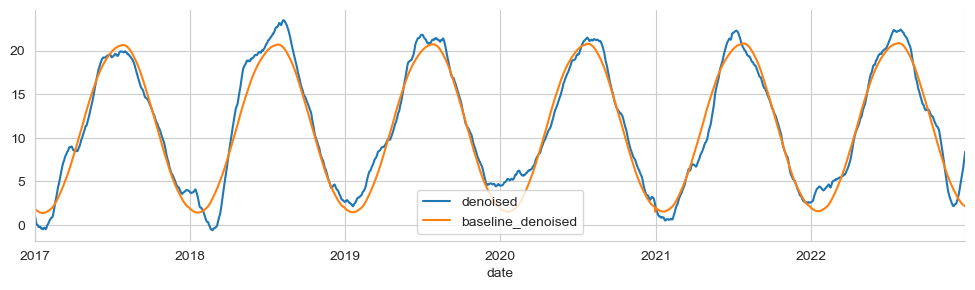

In [51]:
#plot prediction of baseline model vs actual train data

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['denoised','baseline_denoised']]['2017-01-01':'2022-12-31'].plot(legend=True)
sns.despine()

In [52]:
r2_baseline = round(r2_score(train['denoised'],train['baseline_denoised']),6)
print(f"r2_score: {r2_baseline}")

r2_score: 0.941026


## Model Remainder

In [53]:
train['remainder'] = train['denoised'] - train['baseline_denoised']

<AxesSubplot:xlabel='date'>

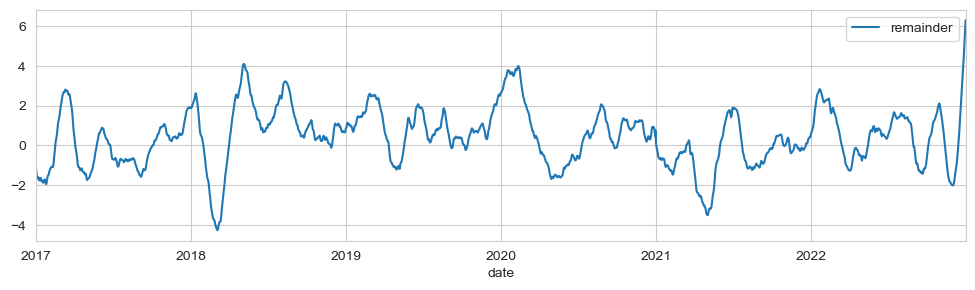

In [54]:
train['remainder']['2017-01-01':'2022-12-31'].plot(legend=True)

In [55]:
qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.423246


after inspecting remainder qsd qcd_variance use log transformation to stabilise mean

In [56]:
train['remainder_trans'] = np.log1p(train['remainder'])

In [57]:
qcd_variance(train['remainder_trans'])

quartile coefficient of dispersion: 0.490544


In [58]:
arima_model = pm.auto_arima(
    train['remainder'],
    max_p=5,
    seasonality = False,
    stationarity = True,
    d=None,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-155910.608, Time=18.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=211090.848, Time=0.63 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=5.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=138235.240, Time=7.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=211088.848, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-142583.534, Time=14.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-155759.746, Time=13.82 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-155037.257, Time=61.66 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-156154.934, Time=20.00 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-147878.158, Time=17.67 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-156272.400, Time=34.37 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-156315.840, Time=18.44 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-155432.593, Time=76.49 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=-156324.427, Time=31

In [59]:
#predictions from arima
#add all up 
#check the score 
#move to test 

In [60]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53691
Model:               SARIMAX(5, 0, 3)   Log Likelihood               78172.499
Date:                Thu, 11 May 2023   AIC                        -156326.998
Time:                        18:39:00   BIC                        -156246.979
Sample:                    01-01-1876   HQIC                       -156302.015
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8416      0.216      8.518      0.000       1.418       2.265
ar.L2         -0.7932      0.453     -1.751      0.080      -1.681       0.095
ar.L3          0.3174      0.338      0.940      0.347      -0.345       0.980
ar.L4         -0.6738      0.296     -2.280      0.023      -1.253      -0.095
ar.L5          0.3064      0.107      2.853      0.004       0.096       0.517
ma.L1         -0.1091      0.216     -0.505      0.614      -0.533       0.314
ma.L2         -0.0927      0.134     -0.693      0.489      -0.355       0.170
ma.L3         -0.4453      0.145     -3.068      0.002      -0.730      -0.161
sigma2         0.0032   8.33e-06    381.818      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           3434870.13
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -1.68
Prob(H) (two-sided):                  0.05   Kurtosis:                        42.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
arima_model.fit(train['remainder'])

ARIMA(order=(5, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [62]:
train['remainder_arima'] = arima_model.predict_in_sample()

## Complete the model

In [63]:
train['full_pred'] = train['remainder_arima'] + train['baseline_denoised']

In [64]:
r2_fullpred = round(r2_score(train['denoised'],train['full_pred']),6)
print(f"r2_score: {r2_fullpred}")

r2_score: 0.999937


### Use ARIMA on the noise

In [65]:
arima_noise = pm.auto_arima(
    train['noise'],
    max_p=5,
    seasonality = False,
    stationarity = True,
    d=None,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=236170.934, Time=8.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=281014.350, Time=0.68 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=237947.817, Time=1.50 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=248842.149, Time=3.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281012.360, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=236168.405, Time=3.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=240177.652, Time=4.91 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=236167.313, Time=3.39 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=236168.317, Time=7.30 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=236244.516, Time=2.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=236165.314, Time=1.76 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=248840.154, Time=1.59 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=237945.817, Time=0.54 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=236166.318, Time=3.39 sec
 ARIM

In [66]:
train['noise_pred'] = arima_noise.predict_in_sample()

In [89]:
train['noise_pred']

date
1876-01-01    0.000000
1876-01-02    2.124101
1876-01-03    2.356588
1876-01-04    0.448041
1876-01-05   -4.311954
                ...   
2022-12-27    2.959906
2022-12-28   -3.032289
2022-12-29   -0.066639
2022-12-30    2.118865
2022-12-31   -0.885694
Name: noise_pred, Length: 53691, dtype: float64

In [67]:
r2_noise = round(r2_score(train['noise'],train['noise_pred']),6)
print(f"r2_score: {r2_noise}")

r2_score: 0.566279


In [68]:
qcd_variance(train['noise'])

quartile coefficient of dispersion: 0.155881


<AxesSubplot:xlabel='date'>

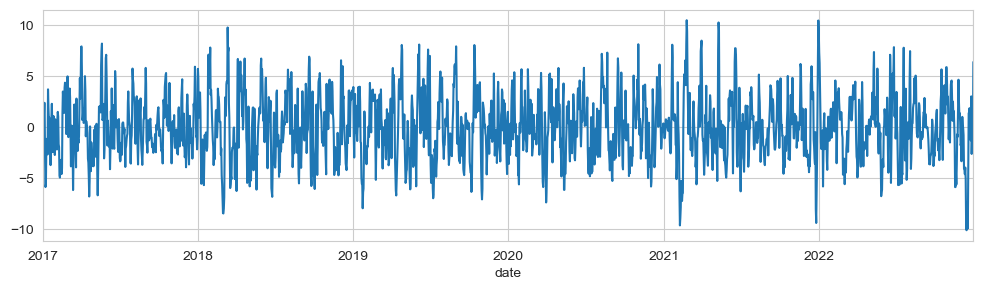

In [69]:
train['noise']['2017-01-01':'2022-12-31'].plot()

In [90]:
train['full_pred_noisy']= train['noise_pred'] + train['full_pred']

In [91]:
r2_rull_train = round(r2_score(train['temp'],train['full_pred_noisy']),6)
print(f"r2_score: {r2_rull_train}")

r2_score: 0.923202


Adding noise predictions made r2 score worse -> maybe do more pre-work with it first

## Test Data

### Baseline Model

In [70]:
test['timestep'] = list(range(train.shape[0], train.shape[0] + test.shape[0]))

In [71]:
train['timestep']

date
1876-01-01        0
1876-01-02        1
1876-01-03        2
1876-01-04        3
1876-01-05        4
              ...  
2022-12-27    53686
2022-12-28    53687
2022-12-29    53688
2022-12-30    53689
2022-12-31    53690
Name: timestep, Length: 53691, dtype: int64

In [72]:
test['timestep']

date
2023-01-01    53691
2023-01-02    53692
2023-01-03    53693
2023-01-04    53694
2023-01-05    53695
              ...  
2023-03-27    53776
2023-03-28    53777
2023-03-29    53778
2023-03-30    53779
2023-03-31    53780
Name: timestep, Length: 90, dtype: int64

In [73]:
X_trend_t = test[['timestep']]
y_trend_t = test['denoised']

In [74]:
trend_model.fit(X_trend_t,y_trend_t)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [75]:
test['trend_denoised'] = trend_model.predict(X_trend_t)

In [76]:

test['detrended_d'] = test['denoised'] - test['trend_denoised']

In [77]:
X_season_t = clean_df.loc['2023-01-01':, ['seasonality']]
y_season_t = test['detrended_d']

In [78]:
X_season_t

,seasonality
date,
2023-01-01,0.000000
2023-01-02,0.002738
2023-01-03,0.005476
2023-01-04,0.008214
2023-01-05,0.010952
...,...
2023-03-27,0.232724
2023-03-28,0.235462
2023-03-29,0.238200


In [79]:
seasonality_model.fit(X_season_t, y_season_t)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [80]:
test['seasonality'] = seasonality_model.predict(X_season_t)

In [81]:
#baseline model
test['baseline_denoised'] = test['trend_denoised'] + test['seasonality']

### Remainder

In [82]:
test['remainder'] = test['denoised'] - test['baseline_denoised']

In [84]:
arima_model.predict(n_periods=len(test))

2023-01-01    6.639445
2023-01-02    6.925022
2023-01-03    7.161180
2023-01-04    7.358769
2023-01-05    7.523676
                ...   
2023-03-27   -0.388396
2023-03-28   -0.420412
2023-03-29   -0.449904
2023-03-30   -0.476954
2023-03-31   -0.501640
Freq: D, Length: 90, dtype: float64

In [85]:
test['arima_denoised'] = arima_model.predict(n_periods=len(test))

In [88]:
test['full_pred'] = test['arima_denoised'] + test['baseline_denoised']

In [93]:
r2_denoised_test = round(r2_score(test['temp'],test['full_pred']),6)
print(f"r2_score: {r2_denoised_test}")

r2_score: -1.445136


In [94]:
test[['temp','full_pred']]

,temp,full_pred
date,,
2023-01-01,14.5,16.309892
2023-01-02,13.1,16.285039
2023-01-03,5.6,16.185406
2023-01-04,7.1,16.084267
2023-01-05,8.2,15.967390
...,...,...
2023-03-27,3.4,8.181083
2023-03-28,3.5,8.209144
2023-03-29,6.6,8.226629
